# Set Up

In [1]:
import gensim#For word2vec, etc
from gensim.models import ldaseqmodel

import lucem_illud_2020

import numpy as np #For arrays
import pandas as pd #Gives us DataFrames
import scipy
import matplotlib
import matplotlib.pyplot as plt #For graphics
import wordcloud
import seaborn as sns #makes our plots look nicer

from sklearn.cluster import KMeans
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

import nltk
from nltk.collocations import *

import networkx as nx
import copy

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import re
import string
import os #For looking through files
import os.path #For managing file paths

## Load Data

In [2]:
data = pd.read_pickle("data/coca_data_normalized.pkl")

In [3]:
data.genre.unique()

array(['MAG', 'SPOK', 'NEWS'], dtype=object)

In [4]:
#5-year periods
def get_period(year, startyr, endyr, n=5):
    period_start = []
    for i in range(startyr, endyr+1, n):
        period_start.append(i)
    for index, p in enumerate(period_start):
        if year >= p:
            period = index
            continue
        else:
            break
    return period  
    
data['period'] = data['year'].apply(lambda x: get_period(x, 1991, 2015, n=5) if x>=1991 else 0)

## Labelling Ideology

In [5]:
unique_sources = list(data.source.apply(lambda x: re.split("_|: | ", x)[0]).unique())
len(unique_sources)

109

In [20]:
# Write a function that let us conveniently label ideology: Left, Neutral, Right
media_ideology = {}

def label_ideology(media_title, ideology, media_ideology = media_ideology):
    media_ideology[media_title] = ideology

In [21]:
label_ideology('Money', 'Neutral')
label_ideology('MotherEarth', 'Neutral')
label_ideology('MotherJones', 'Left')
label_ideology('AmHeritage', 'Neutral')
label_ideology('AmSpect', 'Right')
label_ideology('Forbes', 'Right')
label_ideology('NatlReview', 'Right')
label_ideology('Newsweek', 'Left')
label_ideology('ScienceNews', 'Neutral')
label_ideology('Smithsonian', 'Neutral')
label_ideology('USNWR', 'Left')
label_ideology('WashMonth', 'Left')
label_ideology('ChangingTimes', 'Right')
label_ideology('HistoryToday', 'Neutral')
label_ideology('Omni', 'Neutral')
label_ideology('Wilderness', 'Neutral')
label_ideology('TIME', 'Left')
label_ideology('NatlParks', 'Neutral')
label_ideology('AmerArtist', 'Neutral')
label_ideology('RollingStone', 'Left')
label_ideology('Americas', 'Neutral')
label_ideology('SportsIll', 'Neutral')
label_ideology('Ms', 'Left')
label_ideology('PopScience', 'Neutral')
label_ideology('Futurist', 'Neutral')
label_ideology('HarpersMag', 'Left')
label_ideology('Fortune', 'Right')
label_ideology('USAToday', 'Left')
label_ideology('America', 'Left')
label_ideology('ChristCentury', 'Right')
label_ideology('People', 'Left')
label_ideology('Jet', 'Left')
label_ideology('Aging', 'Neutral')
label_ideology('Horticulture', 'Neutral')
label_ideology('NewRepublic', 'Left')
label_ideology('Conservation', 'Left')
label_ideology('NaturalHist', 'Neutral')
label_ideology('Atlantic', 'Left')
label_ideology('Inc.', 'Neutral')
label_ideology('ChildrenToday', 'Neutral')
label_ideology('Ebony', 'Left')
label_ideology('ConsumResrch', 'Neutral')
label_ideology('SatEvenPost', 'Neutral')
label_ideology('ChristToday', 'Right')
label_ideology('Backpacker', 'Neutral')
label_ideology('AmericanCraft', 'Neutral')
label_ideology('ArtAmerica', 'Neutral')
label_ideology('SportingNews', 'Neutral')
label_ideology('MensHealth', 'Neutral')
label_ideology('Antiques', 'Neutral')
label_ideology('Parenting', 'Neutral')
label_ideology('Essence', 'Neutral')
label_ideology('Environmental', 'Neutral')
label_ideology('USCatholic', 'Right')
label_ideology('MilitaryHist', 'Neutral')
label_ideology('PsychToday', 'Neutral')
label_ideology('Cosmopolitan', 'Left')
label_ideology('Redbook', 'Neutral')
label_ideology('Bazaar', 'Left')
label_ideology('ChildDigest', 'Neutral')
label_ideology('Bicycling', 'Neutral')
label_ideology('Shape', 'Neutral')
label_ideology('NatGeog', 'Neutral')
label_ideology('Entertainment', 'Neutral')
label_ideology('Astronomy', 'Neutral')
label_ideology('TownCountry', 'Neutral')
label_ideology('TotalHealth', 'Neutral')
label_ideology('Esquire', 'Left')
label_ideology('FieldStream', 'Neutral')
label_ideology('TechReview', 'Neutral')
label_ideology('CountryLiving', 'Neutral')
label_ideology('VegTimes', 'Neutral')
label_ideology('SouthernLiv', 'Neutral')
label_ideology('Skiing', 'Neutral')
label_ideology('ConsumRep', 'Neutral')
label_ideology('Sunset', 'Neutral')
label_ideology('HarpersBazaar', 'Neutral')
label_ideology('AmericanSpectator', 'Right')
label_ideology('GoodHousekeeping', 'Neutral')
label_ideology('PopMech', 'Neutral')
label_ideology('MHQTheQuarterly', 'Neutral')
label_ideology('TodaysParent', 'Neutral')
label_ideology('NationalGeographic', 'Neutral')
label_ideology('EEnvironmental', 'Neutral')
label_ideology('ParentingEarly', 'Neutral')
label_ideology('ABC', 'Left')
label_ideology('CNN', 'Left')
label_ideology('PBS', 'Left')
label_ideology('CBS', 'Left')
label_ideology('Ind', 'Left')
label_ideology('NPR', 'Left')
label_ideology('NBC', 'Left')
label_ideology('Fox', 'Right')
label_ideology('MSNBC', 'Left')
label_ideology('NYTimes', 'Left')
label_ideology('CSMonitor', 'Neutral')
label_ideology('AssocPress', 'Neutral')
label_ideology('WashPost', 'Left')
label_ideology('SanFranChron', 'Left')
label_ideology('Atlanta', 'Left') #Atlanta Journal Constitution
label_ideology('Houston', 'Left') #Houston Chronicle
label_ideology('Chicago', 'Left') #Chicago Sun-Times
label_ideology('Denver', 'Left') #Denver Post
label_ideology('GolfMag', 'Neutral')
label_ideology('NewStatesman', 'Left')
label_ideology('Austin', 'Left') #Austin American Statesman
label_ideology('STLouis', 'Left') #St Louis Post_Dispatch
label_ideology('Pittsburgh', 'Right') #Pittsburgh Post-Gazette
label_ideology('OrangeCR', 'Right') #Orange County Register

In [22]:
media_ideology

{'Money': 'Neutral',
 'MotherEarth': 'Neutral',
 'MotherJones': 'Left',
 'AmHeritage': 'Neutral',
 'AmSpect': 'Right',
 'Forbes': 'Right',
 'NatlReview': 'Right',
 'Newsweek': 'Left',
 'ScienceNews': 'Neutral',
 'Smithsonian': 'Neutral',
 'USNWR': 'Left',
 'WashMonth': 'Left',
 'ChangingTimes': 'Right',
 'HistoryToday': 'Neutral',
 'Omni': 'Neutral',
 'Wilderness': 'Neutral',
 'TIME': 'Left',
 'NatlParks': 'Neutral',
 'AmerArtist': 'Neutral',
 'RollingStone': 'Left',
 'Americas': 'Neutral',
 'SportsIll': 'Neutral',
 'Ms': 'Left',
 'PopScience': 'Neutral',
 'Futurist': 'Neutral',
 'HarpersMag': 'Left',
 'Fortune': 'Right',
 'USAToday': 'Left',
 'America': 'Left',
 'ChristCentury': 'Right',
 'People': 'Left',
 'Jet': 'Left',
 'Aging': 'Neutral',
 'Horticulture': 'Neutral',
 'NewRepublic': 'Left',
 'Conservation': 'Left',
 'NaturalHist': 'Neutral',
 'Atlantic': 'Left',
 'Inc.': 'Neutral',
 'ChildrenToday': 'Neutral',
 'Ebony': 'Left',
 'ConsumResrch': 'Neutral',
 'SatEvenPost': 'Neutral',

In [23]:
#add political leaning label
def add_ideology(x, media_ideology=media_ideology):
    try_split = re.split("_|: | ",x)
    if len(try_split)>1:
        x = try_split[0]
    if x in media_ideology:
        return media_ideology[x]
    else:
        print('{} does not exists'.format(x))

data["ideology"] = data['source'].apply(add_ideology)

In [24]:
data.groupby(['ideology','period']).size()

ideology  period
Left      0         890
          1         526
          2         548
          3         344
          4         420
Neutral   0         275
          1         165
          2         170
          3         185
          4         198
Right     0          57
          1          37
          2          48
          3          35
          4          94
dtype: int64

In [11]:
data_left=data[data['ideology']=='Left'].reset_index()
data_right=data[data['ideology']=='Right'].reset_index()

In [18]:
data_left.source.unique()

array(['MotherJones', 'Newsweek', 'USNWR', 'WashMonth', 'TIME',
       'RollingStone', 'Ms', 'HarpersMag', 'USAToday', 'America',
       'People', 'Jet', 'NewRepublic', 'Conservation', 'Atlantic',
       'Ebony', 'Cosmopolitan', 'Bazaar', 'Esquire', 'ABC_20/20',
       'ABC_Special', 'ABC_Brinkley', 'ABC_SunNews', 'ABC_Jennings',
       'CNN_Crossfire', 'CNN_King', 'PBS_Newshour', 'CNN_NewsSat',
       'ABC_Nightline', 'ABC_Primetime', 'ABC_SatNews', 'CNN_Novak',
       'CNN_Moneyline', 'CNN_NewsSun', 'CBS_Sixty', 'CBS_Special',
       'CBS_Morning', 'CBS_FaceNation', 'Ind_Limbaugh', 'CBS_Street',
       'NPR_ATC', 'NPR_Morning', 'CNN_Sonya', 'NPR_Weekend',
       'CBS_48Hours', 'NPR_America', 'ABC_DayOne', 'CBS_SunMorn',
       'CNN_News', 'ABC_WorldNews', 'CBS_EyeToEye', 'ABC_Turning',
       'ABC_GMA', 'ABC_ThisWeek', 'CNN_KingWknd', 'CNN_Morning',
       'NPR_TalkNation', 'NPR_Saturday', 'NPR_Sunday', 'CNN_Event',
       'NBC_Dateline', 'Ind_NewsForum', 'NPR_Weekly', 'CNN_Company',

In [17]:
data_right.source.unique()

array(['AmSpect', 'Forbes', 'NatlReview', 'ChangingTimes', 'Fortune',
       'ChristCentury', 'ChristToday', 'USCatholic', 'AmericanSpectator',
       'Fox_Crier', 'Fox_Drudge', 'Fox_HC', 'Fox_Sunday', 'Fox_Hume',
       'Fox_OReilly', 'Fox_Gibson', 'Fox_Cavuto', 'Fox_Zahn', 'Fox_Live',
       'Fox_Hannity', 'Fox_Baier', 'Fox_Journal', 'Fox: The Five',
       'Fox: Fox Hannity', 'Fox: On The Record: Susteren',
       'Fox: Fox News Sunday', 'Fox: On The Record: Baier',
       "Fox: O'Reilly Factor", 'Fox: Hannity'], dtype=object)

In [16]:
data=data_left

## Additional stopwords

In [17]:
names=[]
for word in data[data.genre=='SPOK']['text'].sum().split():
    if word.startswith('!') or word.endswith('#'):
        word = word.translate(str.maketrans('', '', string.punctuation))
        names.append(word)
names

['hughdowns',
 'announcer',
 'announcer',
 'announcer',
 'announcer',
 'announcer',
 'downs',
 'walters',
 'downs',
 'jarriel',
 'jarriel',
 'jarriel',
 'wells',
 'jarriel',
 'wells',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'downs',
 'jarriel',
 'jarriel',
 'franisse',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'downs',
 'downs',
 'downs',
 'jarriel',
 'downs',
 'jarriel',
 'downs',
 'walters',
 'resident',
 'stossel',
 'stossel',
 'stossel',
 'stossel',
 'stossel',
 'stossel',
 'stossel',
 'stossel',
 'stossel',
 '',
 '',
 'son',
 '',
 '',
 '',
 '',
 'stossel',
 'stossel',
 'stossel',
 'stosse

In [18]:
#Frequency Distribution
fdist = nltk.FreqDist([w for w in data['normalized_words'].sum()])
freq = pd.DataFrame.from_dict(fdist, orient='index', columns=['count'])
freq = freq.sort_values(by='count', ascending=False)
freq[:50]

,count
say,32864
people,28480
think,27409
mr,24439
go,24313
know,21797
year,18779
come,17160
like,16449
time,16288


In [19]:
# remove frequent common words, stop at child
stopwords = freq.index[:38]

In [20]:
# remove top common verbs
freqdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in data['normalized_words_POS'].sum())
topverbs = freqdist_POStoWord['VB'].most_common(50) # stop at protect
stopwords_verbs = [v for v,count in topverbs]

In [21]:
others=['qwq', 'voice-over', 'voiceover','>','+', 'end', 'video', 'clip', 'morning', 'tonight', 'news', 'ms', 
        'mrs', 'mr','s','voice', 'thank', 'watching', 'have', 'good', 'evening', 'weekend', 'night', 'yes', 
        'lot', 'long']
# get rid of other words that are not relevant

stopwords_all=set(stopwords).union(set(stopwords_verbs),set(others), set(names))

#  useful words that we may not want to remove
for r in ['american', 'israel', 'west', 'muslim', 'refugee', 'citizen', 'man', 'woman', 'girl', 'boy', 'demonstrators']:
    stopwords_all.remove(r) 

In [22]:
len(stopwords_all)

10773

In [23]:
stopwords_all

{'',
 'repalbertgorej',
 'drbennett',
 'mskalabia',
 'msmelissaobrien',
 'senqueselvey',
 'maryhowardrepub',
 'msmonicabellucci',
 'deborahwilliams',
 'depu',
 'toddoncamera',
 'panhandler',
 'jezohare',
 'cruickshank',
 'austinmetzger',
 'yegorgaidardepu',
 'myers',
 'sarah',
 'roker',
 'mayortombradley',
 'senlevin',
 'ashalhussein',
 'justicemarshall',
 'senricharddurbin',
 'cocu',
 'jodymanor',
 'qianqichenvice',
 'jeffreygoldberg',
 'johnchrystalbus',
 'roger',
 'norahodonnell',
 'repnewtgingrich',
 'chideya',
 'johnfeinstein',
 'richardlindzenc',
 'davidwright1ab',
 'straw',
 'boehner',
 'mcdonoughyouwill',
 'johnschwartz',
 'bowers',
 'michaelwhitson',
 'nort',
 'garygibbonsitn',
 'mrrichardturcott',
 'juangonzalezdai',
 'adamsteltzner',
 'cbsnewswhitehou',
 'johnchancellorre',
 'mrwodajo',
 'obaiafewerki',
 'colonelalanbeave',
 'sgtartemushill',
 'mccain',
 'meaghantodd1tor',
 'geraldrichmanma',
 'scottmayerowitz',
 'stephenmedvicfr',
 'filmcr',
 'trump',
 'suzanne',
 'ahmediss

In [24]:
# remove all these additional stopwords
def more_stopwords(word_list, stopwords):
    normalized = []
    for w in word_list:
        if w not in stopwords and not w.isnumeric():
            normalized.append(w)
    return normalized

def more_stopwords_POS(word_list_POS, stopwords):
    normalized = []
    for w,p in word_list_POS:
        if w not in stopwords and not w.isnumeric():
            normalized.append((w,p))
    return normalized

data['normalized_words'] = data['normalized_words'].apply(lambda x: more_stopwords(x, stopwords_all))
data['normalized_words_POS'] = data['normalized_words_POS'].apply(lambda x: more_stopwords_POS(x, stopwords_all))
data['normalized_sents'] = data['tokenized_sents'].apply(lambda x: [more_stopwords(lucem_illud_2020.normalizeTokens(s), stopwords_all) for s in x])

In [25]:
# For Topic Models
data_vectoriser = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
dataVects = data_vectoriser.fit_transform(data['text'])
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

data['reduced_tokens'] = data['normalized_words'].apply(lambda x: dropMissing(x, data_vectoriser.vocabulary_.keys()))

In [26]:
data.head()

,index,text_id,text,word_count,year,genre,source,title,publication_info,tokenized_words,normalized_words,normalized_words_POS,tokenized_sents,normalized_sents,period,ideology,reduced_tokens
0,3,2019061,section : movements from socialist to republi...,1754,1990,MAG,MotherJones,Serve the people.,"Vol. 15 Issue 5, p18, 3p, 1 illustration\r\n","[section, movements, from, socialist, to, repu...","[section, movement, socialist, republicans, ge...","[( , _SP), (section, NN), (:, :), (movements, ...","[[section], [movements, from, socialist, to, r...","[[section], [movement, socialist, republicans,...",0,Left,"[movement, republicans, generation, test, outs..."
1,4,2019063,inside a dusty cement-block house with worn ...,6032,1990,MAG,MotherJones,No road to Tahuanti.,"Vol. 15 Issue 5, p36, 11p, 8bw\r\n","[inside, a, dusty, cement, block, house, with,...","[dusty, cement, house, wear, linoleum, floor, ...","[( , _SP), (dusty, JJ), (cement, NN), (-, HYP...","[[inside, a, dusty, cement, block, house, with...","[[dusty, cement, house, wear, linoleum, floor,...",0,Left,"[sit, conference, table, face, short, oil, pas..."
2,19,2020023,section : international europe braces for imm...,1148,1990,MAG,Newsweek,Winter wanderers.,"Vol. 116 Issue 25, p34, 3p, 5c\r\n","[section, international, europe, braces, for, ...","[section, international, europe, brace, hungry...","[( , _SP), (section, NN), (:, :), (internation...","[[section, international, europe, braces, for,...","[[section, international, europe, brace, hungr...",0,Left,"[europe, soviet, wrong, soviet, office, certai..."
3,20,2020071,section : special report if the sanctions do...,1748,1990,MAG,Newsweek,Will they hold?,"Vol. 116 Issue 13, p20, 4p, 3c\r\n","[section, special, report, if, the, sanctions,...","[section, special, report, sanction, push, sad...","[( , _SP), (section, NN), (:, :), (special, JJ...","[[section, special, report, if, the, sanctions...","[[section, special, report, sanction, push, sa...",0,Left,"[special, report, saddam, action, gulf, crisis..."
4,21,2020081,section : society up to now the imagery of e...,2928,1990,MAG,Newsweek,America's changing face.,"Vol. 116 Issue 11, p46, 5p, 6c, 1bw\r\n","[section, society, up, to, now, the, imagery, ...","[section, society, imagery, island, strong, br...","[( , _SP), (section, NN), (:, :), (society, NN...","[[section, society, up, to, now, the, imagery,...","[[section, society, imagery, island, strong, b...",0,Left,"[society, island, strong, room, scene, island,..."


# Analysis 

## 1. What are the immediate context words of refugees?

In [27]:
periods = data['period'].unique()
periods

array([0, 1, 2, 3, 4])

In [28]:
for p in periods:
    chunk = data[data['period']==p]
    post_text = nltk.Text(chunk['tokenized_words'].sum())
    index = nltk.text.ConcordanceIndex(post_text) 
    print(p)
    index.print_concordance('refugee', lines=10) # usually used as adj
    index.print_concordance('refugees', lines=10) # usually used as noun
    print()
    print('similar')
    post_text.similar('refugee', num=20)
    # find other words which appear in the same contexts as the specified word; most similar first
    print()
    print('common context')
    post_text.common_contexts(['refugee'], num=20)
    # find contexts where the specified words appear; list most frequent common contexts first.
    print()

0
Displaying 10 of 757 matches:
s guerrillas as we pass a family of refugee indians from the highlands dressed 
soviet army barracks into emergency refugee camps german officials speak uneasi
ly thatch of hair california shirts refugee in marin county instead he is a tex
of facilitating was not a political refugee washington insisted but a common cr
ng that noriega was not a political refugee but a common criminal fleeing prose
mpment of shock grief and rage as a refugee put it what civilized country would
tead of food production kabre bayah refugee camp ethiopia 1991 by gayle smith g
ren years later as i tramped around refugee camps and peasant villages in latin
ross the un agencies working in the refugee camps in jordan and there will be c
ck families become sick of cramming refugee relatives into single family houses
Displaying 10 of 1834 matches:
tytown later they met three teenage refugees from honduras the last surviving ma
y center casa oscar romero when the refugees brought out

4
Displaying 10 of 372 matches:
ould also do more to respond to the refugee crisis emerging from the conflict i
adations i wondered how i asked the refugee named emmanuel have you ever wonder
rise has stepped james frey fig 2 a refugee from the great decade of american f
ct of landthink of it as a wildlife refugee camp in practice this does n't alwa
 south on changyang road the jewish refugee museum in the old ohel moshe synago
rheated materialism of china or the refugee camps of somalia even zin mar aung 
nds at over 1,000 in addition a u.n refugee agency says as many as 100,000 peop
eep moving they do nt want to get a refugee camp built up here but there are so
e to get them out and so there is a refugee crisis building here bob schieffer 
 man 's teenage grandson shows up a refugee from his drug- addicted mom in this
Displaying 10 of 759 matches:
of the ottoman empire certainly the refugees have the right to return according 
tional migration i spoke with three refugees on their way

In [29]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in lucem_illud_2020.spacy_pos(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

def plot_word_graph(graph):
    layout = nx.spring_layout(graph, weight='weight', iterations= 100)
    fig, ax = plt.subplots(figsize = (10,10))
    nx.draw(graph, ax = ax, pos = layout, labels = {n:n for n in graph.nodes()},
            width=.2, 
            alpha = .9, 
            node_size = 100,
            node_color = "xkcd:light red",
            edge_color='xkcd:black')

def plot_word_centrality(g):
    layout_nn = nx.spring_layout(g, weight='weight', iterations= 100)
    fig, ax = plt.subplots(figsize = (10,10))
    centralities_nn = nx.eigenvector_centrality(g)
    maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
    #maxWeight = max((d['weight'] for n1, n2, d in g.edges(data = True)))
    #minWeight = min((d['weight'] for n1, n2, d in g.edges(data = True)))
    nx.draw(g, ax = ax, pos = layout_nn, labels = {n: n for n in g.nodes()},
            #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
            alpha = .9, 
            node_color = [centralities_nn[n] / maxC for n in g.nodes],
            node_size = [centralities_nn[n] / maxC * 100 for n in g.nodes],
            font_size = 16,
            font_color = 'xkcd:dark grey',
            edge_color = 'xkcd:medium blue',
            cmap = plt.get_cmap('plasma'),
           )

In [30]:
# plot word network
#g = wordCooccurrence(data['normalized_sents'].sum())
#len(g)

## 2. What topics are discussed about refugees or closely with refugees from the media?

In [31]:
data.period.unique()

array([0, 1, 2, 3, 4])

In [32]:
# set up required data dir
import os
if not os.path.exists("topicmodels"):
    os.makedirs("topicmodels")
    print("/topicmodels created")
else:
    print("/topicmodels already exisits")
    
# Topic Modelling
for n in [5,10,20,50,100]:
    for p in periods:
        p_data = data[data['period']==p]
        # creating dictionary
        dictionary = gensim.corpora.Dictionary(p_data['reduced_tokens'])
        corpus = [dictionary.doc2bow(text) for text in p_data['reduced_tokens']]
        # serialize
        #gensim.corpora.MmCorpus.serialize('data.mm', corpus)
        #data_mm = gensim.corpora.MmCorpus('data.mm')
        # topic modelling
        topics=n
        data_lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=topics, alpha='auto', eta='auto')
        data_lda.save("topicmodels/data_lda_p{}_{}".format(p, n))

/topicmodels already exisits


In [33]:
if os.path.exists("topicmodels"):
    for n in [5,10,20,50,100]:
        for p in periods:
            file= "topicmodels/data_lda_p{}_{}".format(p, n)
            data_lda = gensim.models.ldamodel.LdaModel.load(file)
            for i in range(data_lda.num_topics):
                print("Number of topics: {}, Period: {},  Topic {}".format(n,p,i))
                print(data_lda.show_topic(i, topn=20))
                print()
else:
    print("No topic models found")

Number of topics: 5, Period: 0,  Topic 0
[('problem', 0.01068043), ('force', 0.010096313), ('woman', 0.008347939), ('refugee', 0.0076180203), ('report', 0.007359011), ('saddam', 0.006796788), ('iraqi', 0.006561085), ('economic', 0.0063046357), ('job', 0.0061527877), ('lehrer', 0.0061245277), ('percent', 0.00600427), ('issue', 0.0059012775), ('macneil', 0.0058084666), ('plan', 0.0052680713), ('leader', 0.0050556385), ('community', 0.0047676302), ('care', 0.004690555), ('soviet', 0.004656013), ('serbs', 0.0046112495), ('hope', 0.0045924177)]

Number of topics: 5, Period: 0,  Topic 1
[('problem', 0.00964721), ('woman', 0.0076724337), ('job', 0.0067574903), ('refugee', 0.006426032), ('lehrer', 0.0064163716), ('force', 0.006068803), ('percent', 0.0056884205), ('program', 0.005677501), ('care', 0.0056027444), ('case', 0.005287615), ('plan', 0.005271699), ('official', 0.005135319), ('money', 0.005058554), ('break', 0.0049873805), ('issue', 0.0049779364), ('month', 0.0048047914), ('community',

[('woman', 0.012207999), ('report', 0.0092599755), ('unidentified', 0.0079020625), ('york', 0.0077308677), ('area', 0.00723305), ('problem', 0.0069902227), ('big', 0.006955533), ('north', 0.0068659433), ('official', 0.0065043066), ('picture', 0.0063178), ('break', 0.006262239), ('actually', 0.0058686677), ('company', 0.005851861), ('hour', 0.005844977), ('afghanistan', 0.005757096), ('money', 0.005684609), ('case', 0.005588498), ('run', 0.0053441846), ('story', 0.005087867), ('organization', 0.0050827176)]

Number of topics: 50, Period: 2,  Topic 34
[('aid', 0.019902252), ('report', 0.011861203), ('kill', 0.009594097), ('drug', 0.009348605), ('bomb', 0.009085631), ('refugee', 0.008759866), ('story', 0.008665004), ('camp', 0.007944469), ('woman', 0.007860594), ('die', 0.0076272227), ('hope', 0.007038049), ('god', 0.00700533), ('small', 0.007001512), ('water', 0.0068251947), ('america', 0.00661238), ('unidentified', 0.0062642517), ('americans', 0.00607597), ('percent', 0.006037067), ('fo

[('report', 0.013937056), ('unidentified', 0.010652399), ('force', 0.009137917), ('run', 0.008467982), ('aid', 0.007977913), ('story', 0.0073157772), ('case', 0.006625644), ('water', 0.006310929), ('big', 0.006231759), ('course', 0.0060828947), ('official', 0.0057926187), ('street', 0.0057447446), ('face', 0.005715296), ('money', 0.0056479736), ('taliban', 0.005636596), ('break', 0.005617594), ('friend', 0.005414408), ('york', 0.0054135784), ('turn', 0.0053151622), ('hope', 0.005263626)]

Number of topics: 100, Period: 2,  Topic 11
[('job', 0.011355144), ('street', 0.007986277), ('free', 0.0075550214), ('america', 0.007541852), ('refugee', 0.0074293637), ('attack', 0.007198046), ('build', 0.0071586487), ('play', 0.0071177413), ('fight', 0.0069627487), ('woman', 0.0068536494), ('plan', 0.0066840346), ('member', 0.0064875963), ('issue', 0.00646059), ('report', 0.0060202116), ('hope', 0.005977881), ('strong', 0.0059655798), ('kill', 0.005741923), ('ii', 0.0055284817), ('middle', 0.0054755

In [34]:
def plot_topics(data_lda, dictionary, data, title, n=10):
    data_ldaDF = create_lda_df(data_lda, dictionary, data)
    data_ldaDFV = data_ldaDF[:n][['topic_%d' %x for x in range(data_lda.num_topics)]]
    data_ldaDFVisN = data_ldaDF[:n][['text_id']]
    data_ldaDFVis = data_ldaDFV.values
    data_ldaDFVisNames = data_ldaDFVisN.values
    plot_topics_barchart(data_lda, data_ldaDFVis, data_ldaDFVisNames, title, n)
    return data_ldaDF

def create_lda_df(data_lda, dictionary, data):
    # create a df of text and topics
    data_ldaDF = pd.DataFrame({
                'text_id' : data['text_id'],
                'title': data['title'],
                'year': data['year'],
                'topics' : [data_lda[dictionary.doc2bow(l)] for l in data['reduced_tokens']]
        })

    #Dict to temporally hold the probabilities
    topicsProbDict = {i : [0] * len(data_ldaDF) for i in range(data_lda.num_topics)}

    #Load them into the dict
    for index, topicTuples in enumerate(data_ldaDF['topics']):
        for topicNum, prob in topicTuples:
            topicsProbDict[topicNum][index] = prob

    #Update the DataFrame
    for topicNum in range(data_lda.num_topics):
        data_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]
    return data_ldaDF


def plot_topics_barchart(senlda, ldaDFVis, ldaDFVisNames, title, N):
    ind = np.arange(N)
    K = senlda.num_topics  # N documents, K topics
    ind = np.arange(N)  # the x-axis locations for the novels
    width = 0.5  # the width of the bars
    plots = []
    height_cumulative = np.zeros(N)

    for k in range(K):
        color = plt.cm.coolwarm(k/K, 1)
        if k == 0:
            p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
        else:
            p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
        height_cumulative += ldaDFVis[:, k]
        plots.append(p)


    plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
    plt.ylabel('Topics')

    plt.title(title)
    plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

    plt.yticks(np.arange(0, 1, 10))
    topic_labels = ['Topic #{}'.format(k) for k in range(K)]
    plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

    plt.show()

In [35]:
# n=20
# title = "topics relevant to immigra in first {} documents".format(n)
# plot_topics(data_lda, dictionary, data, title, n=n)

In [36]:
# Dynamic Topic Modelling

# docs_per_year = list(data.groupby('period').size())
# num_topics = 10
# data_ldaseq_5yr = ldaseqmodel.LdaSeqModel(corpus=data_mm, id2word=dictionary, time_slice=docs_per_year, num_topics=num_topics)

In [37]:
# data_ldaseq_5yr.save("data_ldaseq_5yr")

In [38]:
# data_ldaseq_5yr.print_topic_times(topic=0)

## 3. What concepts are associated with refugee over time?

word2vec
* Documentation: https://radimrehurek.com/gensim/models/word2vec.html
* Parameters: https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html

In [39]:
# set up required data dir
import os
if not os.path.exists("embeddingplot"):
    os.makedirs("embeddingplot")
    print("/embeddingplot created")
else:
    print("/embeddingplot already exisits")

def plot_embeddings(data_w2v, numWords, save=False, title=''):
    targetWords = data_w2v.wv.index2word[:numWords]
    wordsSubMatrix = []
    for word in targetWords:
        wordsSubMatrix.append(data_w2v[word])
    wordsSubMatrix = np.array(wordsSubMatrix)
    pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
    reducedPCA_data = pcaWords.transform(wordsSubMatrix)
    #T-SNE is theoretically better, but you should experiment
    tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)
    fig = plt.figure(figsize = (10,6))
    ax = fig.add_subplot(111)
    ax.set_frame_on(False)
    plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
    for i, word in enumerate(targetWords):
        ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
    plt.xticks(())
    plt.yticks(())
    plt.show()
    if save:
        fig.savefig("embeddingplot/{}".format(title), format='png')

/embeddingplot already exisits


Period 0
[('haitians', 0.845333456993103), ('flee', 0.8317835927009583), ('cuban', 0.8071789145469666), ('guantanamo', 0.8029439449310303), ('camp', 0.799612283706665), ('cubans', 0.7988340258598328), ('border', 0.7733670473098755), ('detention', 0.7679306864738464), ('concentration', 0.7647914886474609), ('cuba', 0.7618201971054077)]


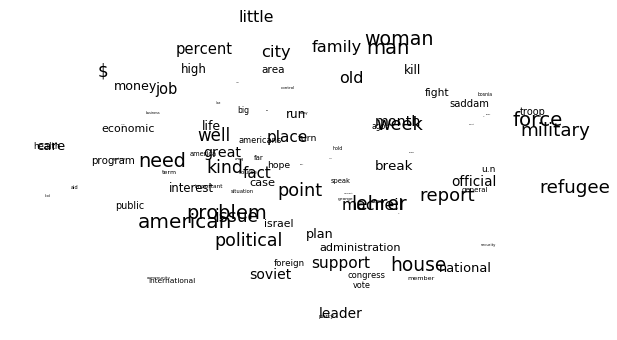

Period 1
[('camp', 0.965694785118103), ('thousand', 0.9538518190383911), ('hundred', 0.9102498292922974), ('return', 0.9058634042739868), ('flee', 0.9018415212631226), ('border', 0.8973280787467957), ('rwanda', 0.8813134431838989), ('hutu', 0.8755816221237183), ('albanian', 0.8683760166168213), ('zaire', 0.8633002638816833)]


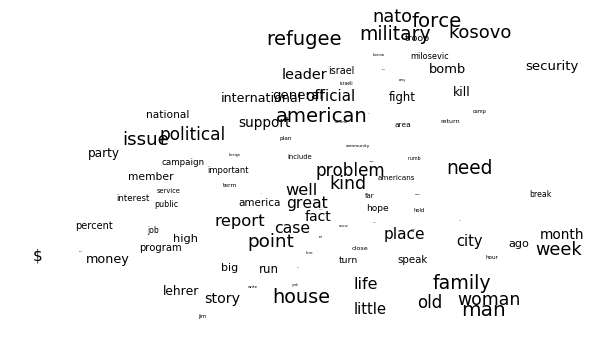

Period 2
[('camp', 0.794736921787262), ('jenin', 0.7907346487045288), ('internment', 0.7884203791618347), ('afghan', 0.769889235496521), ('flee', 0.7672621011734009), ('border', 0.7616885900497437), ('thousand', 0.7512044906616211), ('pakistan', 0.7421414256095886), ('train', 0.7409456968307495), ('phalangists', 0.736586332321167)]


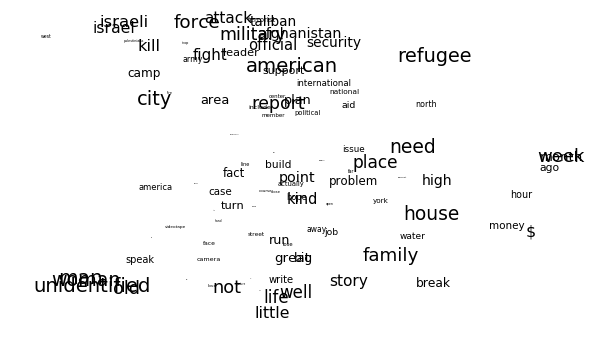

Period 3
[('camp', 0.9858708381652832), ('border', 0.9831007122993469), ('official', 0.9829621911048889), ('lebanese', 0.9827432632446289), ('flee', 0.9824714660644531), ('southern', 0.9817509651184082), ('syria', 0.9809232950210571), ('iraqi', 0.980646550655365), ('army', 0.9805116057395935), ('attack', 0.9800186157226562)]


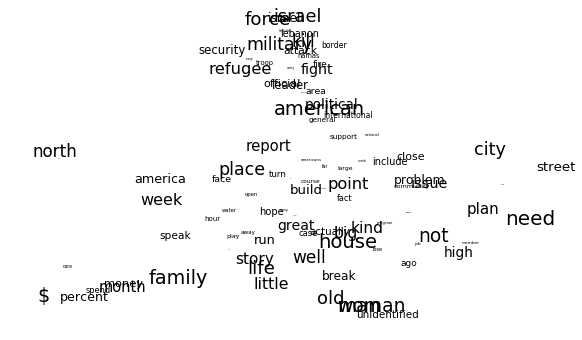

Period 4
[('border', 0.9422886967658997), ('camp', 0.9421865940093994), ('flee', 0.9249111413955688), ('migrant', 0.922609806060791), ('thousand', 0.9198862910270691), ('turkey', 0.912543535232544), ('europe', 0.9086136817932129), ('lebanon', 0.8931483030319214), ('cross', 0.8920233249664307), ('humanitarian', 0.8869365453720093)]


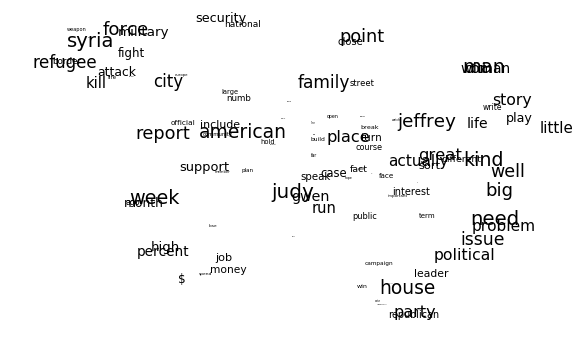

In [40]:
# By 5-year periods
period_w2v = {}
for p in periods:
    chunks = data[data['period']==p]
    data_w2v = gensim.models.word2vec.Word2Vec(chunks['normalized_sents'].sum())
    period_w2v[p] = data_w2v
    print("Period {}".format(p))
    print(data_w2v.most_similar(positive=['refugee']))
    plot_embeddings(data_w2v, 100, save=True, title='period_{}.png'.format(p))

In [41]:
period_w2v

{0: <gensim.models.word2vec.Word2Vec at 0x14727ca90>,
 1: <gensim.models.word2vec.Word2Vec at 0x1f8e77b20>,
 2: <gensim.models.word2vec.Word2Vec at 0x1f8ab9be0>,
 3: <gensim.models.word2vec.Word2Vec at 0x1e7248280>,
 4: <gensim.models.word2vec.Word2Vec at 0x1e712ea60>}

## 4. How are countries/identities associated with refugees over time?
* Countries: countrylist library
* Identities: citizenship (e.g. iraqi, chinese, etc.), religion, demographic (male, female, mother, father, child/children, etc.)
* Dimensions: legal-illegal, accept-ban, refugee-native


In [42]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

def makeDF(model, word_list, Dim1, Dim2, Dim3, dim1_label, dim2_label, dim3_label):
    dim1 = []
    dim2 = []
    dim3 = []
    for word in word_list:
        dim1.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Dim1.reshape(1,-1))[0][0])
        dim2.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Dim2.reshape(1,-1))[0][0])
        dim3.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Dim3.reshape(1,-1))[0][0])
    df = pd.DataFrame({dim1_label: dim1, dim2_label: dim2, dim3_label: dim3}, index = word_list)
    return df

def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

In [43]:
def get_common_words():
    words = {}
    common = []

    for p in periods:
        vocab = list(period_w2v[p].wv.vocab.keys())
        for v in vocab:
            if v in words:
                words[v] += 1
            else:
                words[v] = 1
    for w, count in words.items():
        if count >= len(periods):
            # word in all periods
            common.append(w)
    return common

common = get_common_words()
len(common)

5232

#### Country Analysis

In [44]:
from country_list import countries_for_language
countries = dict(countries_for_language('en'))
countrylist = list(c.lower() for c in countries.values())
countrylist_all = countrylist + ['soviet', 'palestine']
countrylist_all

['afghanistan',
 'åland islands',
 'albania',
 'algeria',
 'american samoa',
 'andorra',
 'angola',
 'anguilla',
 'antarctica',
 'antigua & barbuda',
 'argentina',
 'armenia',
 'aruba',
 'ascension island',
 'australia',
 'austria',
 'azerbaijan',
 'bahamas',
 'bahrain',
 'bangladesh',
 'barbados',
 'belarus',
 'belgium',
 'belize',
 'benin',
 'bermuda',
 'bhutan',
 'bolivia',
 'bosnia & herzegovina',
 'botswana',
 'brazil',
 'british indian ocean territory',
 'british virgin islands',
 'brunei',
 'bulgaria',
 'burkina faso',
 'burundi',
 'cambodia',
 'cameroon',
 'canada',
 'canary islands',
 'cape verde',
 'caribbean netherlands',
 'cayman islands',
 'central african republic',
 'ceuta & melilla',
 'chad',
 'chile',
 'china',
 'christmas island',
 'cocos (keeling) islands',
 'colombia',
 'comoros',
 'congo - brazzaville',
 'congo - kinshasa',
 'cook islands',
 'costa rica',
 'côte d’ivoire',
 'croatia',
 'cuba',
 'curaçao',
 'cyprus',
 'czechia',
 'denmark',
 'diego garcia',
 'djibou

In [45]:
countries_w2v = []
for country in countrylist:
    if country in common:
        countries_w2v.append(country.lower())

In [46]:
# Word counts over periods
country_byperiod = {}
for p in periods:
    for word in data[data['period']==p]['tokenized_words'].sum():
        if word in countrylist_all:
            p=str(p)
            if p not in country_byperiod:
                country_byperiod[p] = {}
            if word not in country_byperiod[p]:
                country_byperiod[p][word] = 1
            else:
                country_byperiod[p][word] +=1

In [47]:
for p in periods:
    print("Period {}".format(p))
    print(country_byperiod[str(p)])
    print()

Period 0
{'vietnam': 749, 'honduras': 17, 'peru': 32, 'mexico': 198, 'haiti': 1016, 'china': 587, 'brazil': 26, 'bolivia': 11, 'ecuador': 6, 'soviet': 1851, 'israel': 1569, 'italy': 123, 'poland': 162, 'germany': 715, 'norway': 14, 'hungary': 63, 'romania': 45, 'switzerland': 36, 'austria': 27, 'france': 228, 'iraq': 2273, 'kuwait': 1196, 'syria': 240, 'canada': 127, 'oman': 6, 'iran': 451, 'india': 116, 'philippines': 52, 'libya': 52, 'jordan': 572, 'lebanon': 265, 'turkey': 250, 'australia': 18, 'ethiopia': 155, 'lithuania': 118, 'russia': 660, 'panama': 199, 'cuba': 607, 'finland': 25, 'thailand': 65, 'ukraine': 53, 'colombia': 26, 'aruba': 1, 'spain': 42, 'ireland': 145, 'egypt': 206, 'malta': 2, 'grenada': 42, 'greece': 26, 'cyprus': 19, 'pakistan': 87, 'nicaragua': 67, 'chile': 7, 'turkmenistan': 4, 'azerbaijan': 130, 'armenia': 89, 'bangladesh': 31, 'sudan': 110, 'angola': 40, 'mozambique': 54, 'ghana': 9, 'guinea': 15, 'somalia': 520, 'belgium': 18, 'liberia': 73, 'kenya': 55, 

In [48]:
country_byperiod_df = pd.DataFrame.from_dict(country_byperiod, orient='index')
country_byperiod_df.dropna(axis='columns', how='all', inplace=True)
country_byperiod_df

,vietnam,honduras,peru,mexico,haiti,china,brazil,bolivia,ecuador,soviet,...,qatar,micronesia,tuvalu,greenland,kiribati,anguilla,martinique,kyrgyzstan,nauru,andorra
0,749,17,32,198,1016,587,26,11.0,6,1851,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,182,13,22,139,163,433,12,11.0,8,157,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,155,6,17,115,75,240,15,20.0,10,122,...,11.0,NaN,38.0,5.0,1.0,1.0,NaN,NaN,NaN,NaN
3,111,17,7,127,189,351,10,17.0,6,48,...,9.0,1.0,12.0,9.0,NaN,NaN,1.0,7.0,NaN,NaN
4,142,41,3,152,42,312,46,NaN,7,136,...,113.0,NaN,NaN,9.0,NaN,NaN,NaN,NaN,1.0,3.0


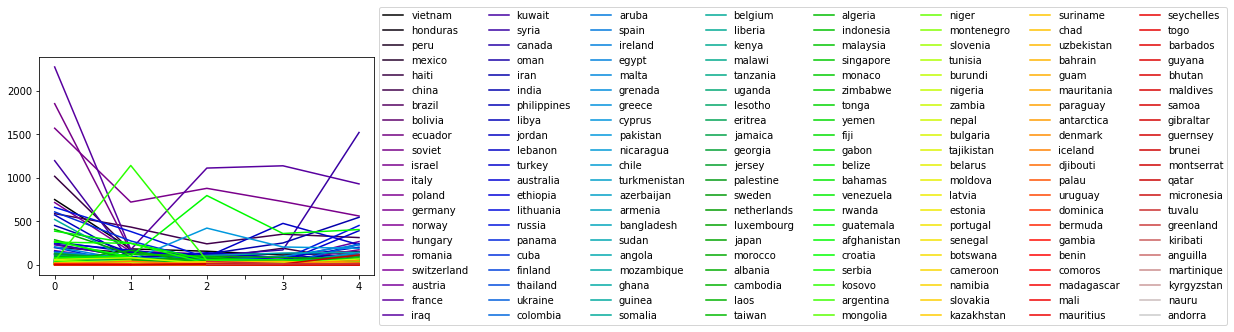

In [49]:
country_byperiod_df.plot(colormap='nipy_spectral')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),ncol=8)

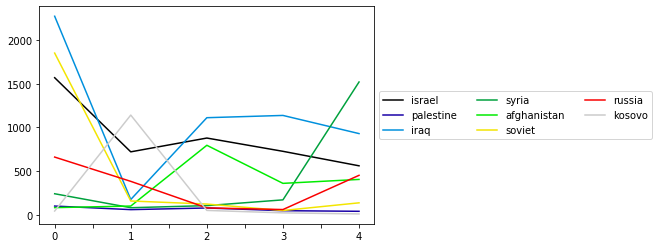

In [50]:
selected=['israel','palestine','iraq','syria','afghanistan','soviet','russia','kosovo']
country_byperiod_df[selected].plot(colormap='nipy_spectral')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),ncol=3)

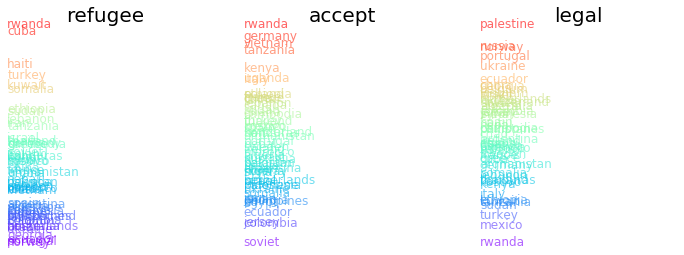

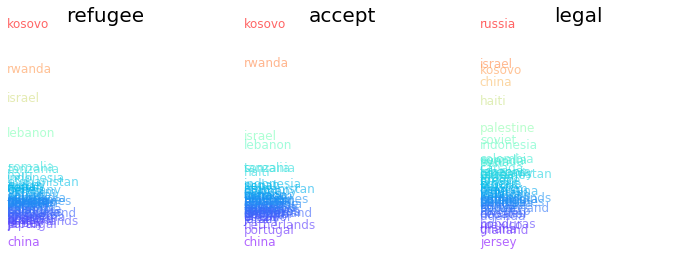

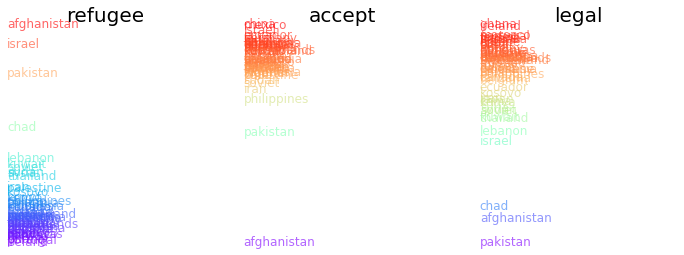

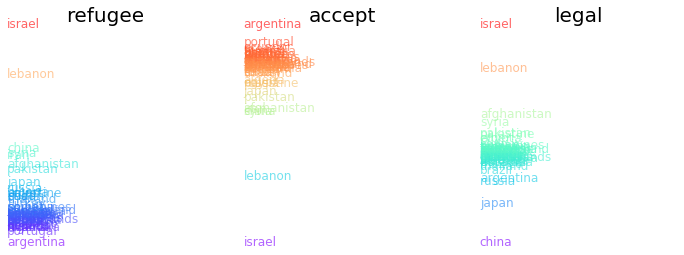

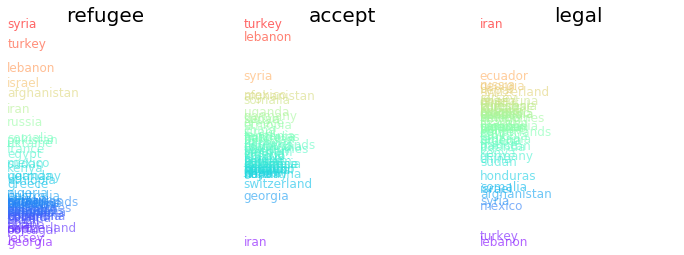

In [51]:
# W2V Dimensions for Countries
countries_full = countries_w2v + ['soviet', 'palestine']

for p in periods:
    model = period_w2v[p]
    Refugee = dimension(model, ['refugee','flee'], ['native','remain'])
    Accept = dimension(model, ['welcome', 'accept'], ['ban','reject'])
    Legal = dimension(model, ['legal'], ['illegal'])
    df = makeDF(model, countries_full, Refugee, Accept, Legal, 'refugee', 'accept', 'legal') 
    fig = plt.figure(figsize = (12,4))
    ax1 = fig.add_subplot(131)
    PlotDimension(ax1, df, 'refugee')
    ax2 = fig.add_subplot(132)
    PlotDimension(ax2, df, 'accept')
    ax3 = fig.add_subplot(133)
    PlotDimension(ax3, df, 'legal')
    plt.show

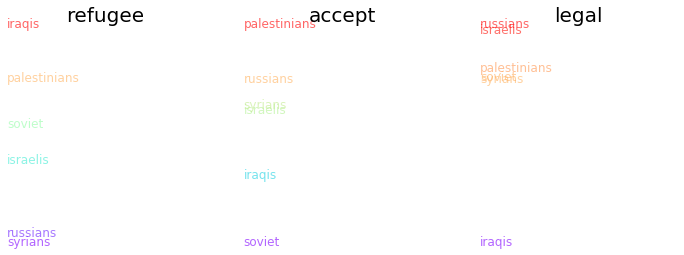

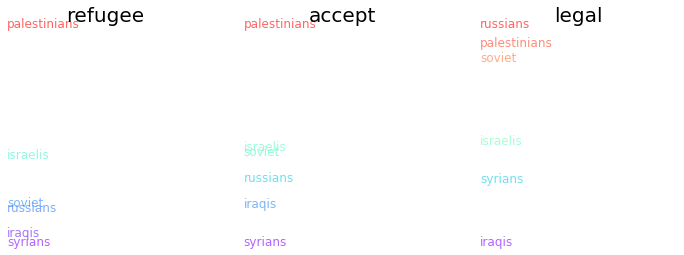

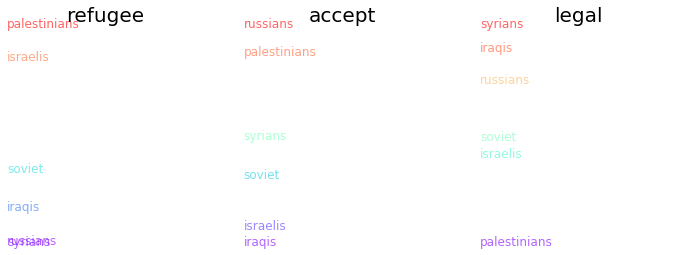

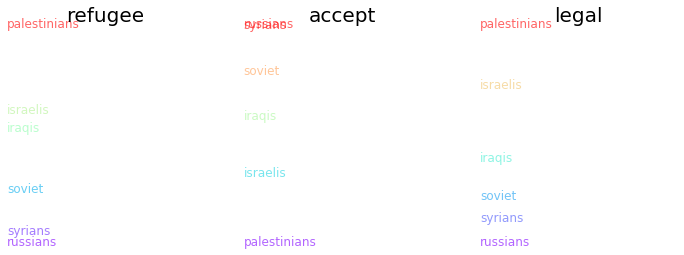

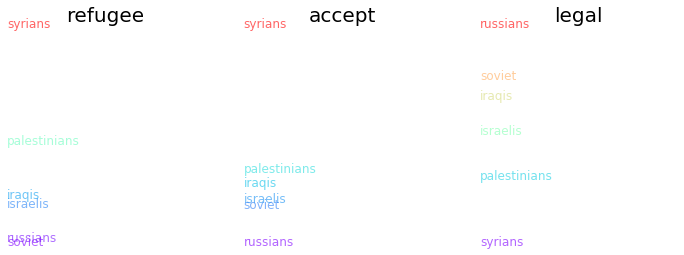

In [52]:
# W2V Dimensions for Citizenship
citizenship=['israelis','palestinians','iraqis','syrians','soviet','russians']

for p in periods:
    model = period_w2v[p]
    Refugee = dimension(model, ['refugee','flee'], ['native','remain'])
    Accept = dimension(model, ['welcome', 'accept'], ['ban','reject'])
    Legal = dimension(model, ['legal'], ['illegal'])
    df = makeDF(model, citizenship, Refugee, Accept, Legal, 'refugee', 'accept', 'legal') 
    fig = plt.figure(figsize = (12,4))
    ax1 = fig.add_subplot(131)
    PlotDimension(ax1, df, 'refugee')
    ax2 = fig.add_subplot(132)
    PlotDimension(ax2, df, 'accept')
    ax3 = fig.add_subplot(133)
    PlotDimension(ax3, df, 'legal')
    plt.show

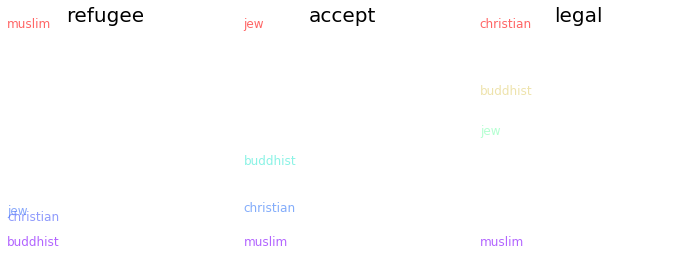

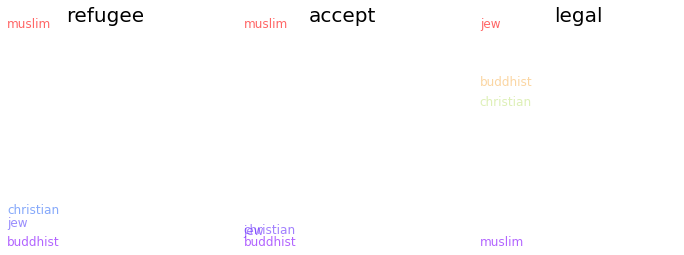

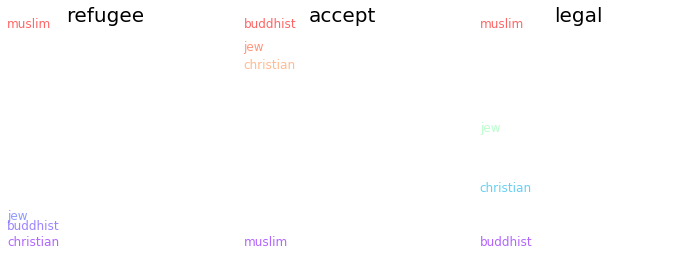

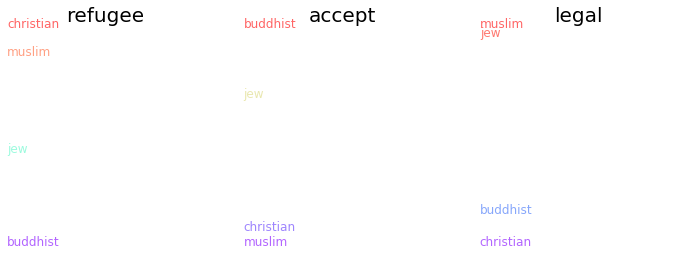

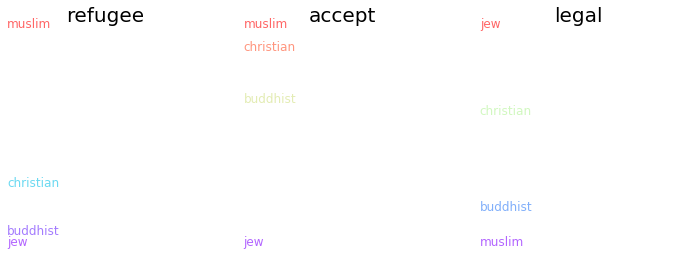

In [54]:
# W2V Dimensions for Religion
religion = ['christian', 'muslim', 'buddhist', 'jew']

for p in periods:
    model = period_w2v[p]
    Refugee = dimension(model, ['refugee','flee'], ['native','remain'])
    Accept = dimension(model, ['welcome', 'accept'], ['ban','reject'])
    Legal = dimension(model, ['legal'], ['illegal'])
    df = makeDF(model, religion, Refugee, Accept, Legal, 'refugee', 'accept', 'legal') 
    fig = plt.figure(figsize = (12,4))
    ax1 = fig.add_subplot(131)
    PlotDimension(ax1, df, 'refugee')
    ax2 = fig.add_subplot(132)
    PlotDimension(ax2, df, 'accept')
    ax3 = fig.add_subplot(133)
    PlotDimension(ax3, df, 'legal')
    plt.show

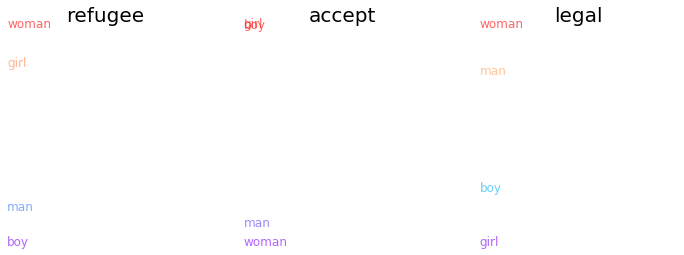

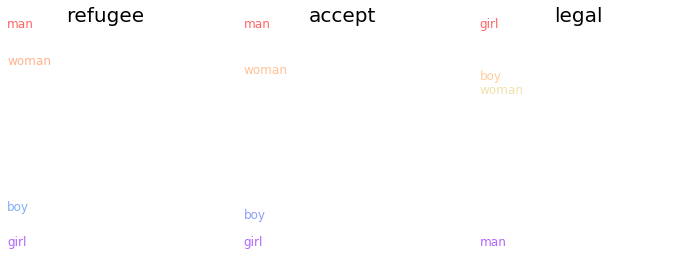

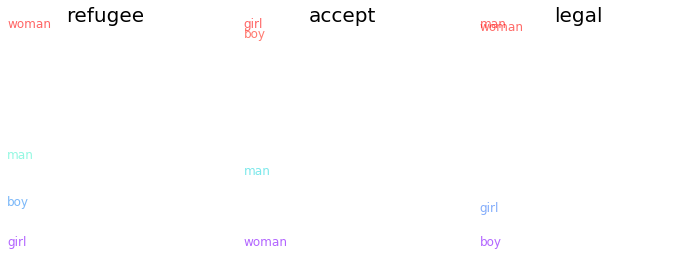

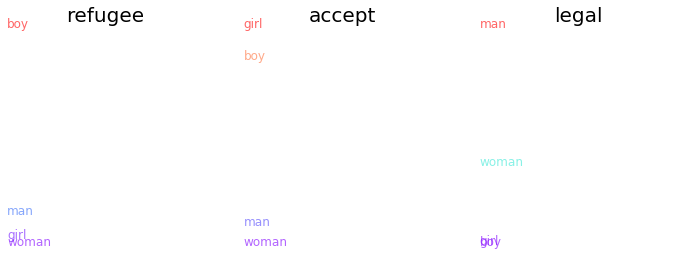

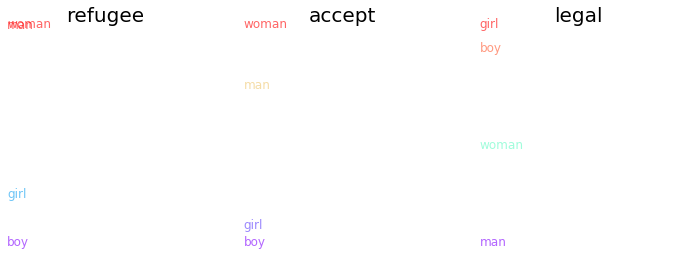

In [56]:
# W2V Dimensions for Demographic
demographic=['man', 'woman', 'girl', 'boy']

for p in periods:
    model = period_w2v[p]
    Refugee = dimension(model, ['refugee','flee'], ['native','remain'])
    Accept = dimension(model, ['welcome', 'accept'], ['ban','reject'])
    Legal = dimension(model, ['legal'], ['illegal'])
    df = makeDF(model, demographic, Refugee, Accept, Legal, 'refugee', 'accept', 'legal') 
    fig = plt.figure(figsize = (12,4))
    ax1 = fig.add_subplot(131)
    PlotDimension(ax1, df, 'refugee')
    ax2 = fig.add_subplot(132)
    PlotDimension(ax2, df, 'accept')
    ax3 = fig.add_subplot(133)
    PlotDimension(ax3, df, 'legal')
    plt.show

## 5. BERT Text Generation